In [1]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Función para procesar un dataset y evaluar el rendimiento
def process_dataset(data, dataset_name):
    global results
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    for n_components in reductions:
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_scaled)
        
        for n_estimators in n_estimators_values:
            for contamination in contamination_values:
                iso_forest = IsolationForest(
                    n_estimators=n_estimators,
                    contamination=contamination,
                    random_state=42
                )
                iso_forest.fit(data_pca)  # Entrenar con el dataset
                
                # Hacer predicciones en el mismo dataset
                predictions = iso_forest.predict(data_pca)
                
                # Convertir -1 (anomalía) a 1 y 1 (normal) a 0
                predictions = np.where(predictions == -1, 1, 0)
                
                # Calcular métricas de evaluación
                num_anomalies = np.sum(predictions == 1)
                percentage_anomalies = num_anomalies / len(data)
                
                if len(np.unique(predictions)) > 1:
                    silhouette = silhouette_score(data_pca, predictions)
                    davies_bouldin = davies_bouldin_score(data_pca, predictions)
                else:
                    silhouette = None
                    davies_bouldin = None
                
                # Guardar resultados
                results.append({
                    "Dataset": dataset_name,
                    "Reducción (PCA)": n_components,
                    "n_estimators": n_estimators,
                    "contamination": contamination,
                    "Anomalías Detectadas": num_anomalies,
                    "Porcentaje Anomalías": percentage_anomalies,
                    "Silhouette Score": silhouette,
                    "Davies-Bouldin Score": davies_bouldin
                })
                

In [3]:

# Configuración de parámetros
reductions = [2, 3, 5, 10, 50, 100]  # Número de componentes principales
n_estimators_values = [25, 50, 100]  # Número de estimadores en Isolation Forest
contamination_values = [ 0.0001, 0.001, 0.01, 0.5]  # Proporción estimada de anomalías

# DataFrame para almacenar resultados
results = []


In [4]:

# Cargar el dataset
data = pd.read_csv('perfcounters_normal_running.csv', header=None)
data = data.drop(columns=[data.columns[0]])

# Procesar el dataset
process_dataset(data, "Dataset 1")

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)


In [5]:

# Mostrar resultados en tablas
print("Resultados de la detección de anomalías:")
print(results_df)

# Exportar resultados a un archivo CSV (opcional)
results_df.to_csv("isolation_forest_results_metrics.csv", index=False)

Resultados de la detección de anomalías:
      Dataset  Reducción (PCA)  n_estimators  contamination  \
0   Dataset 1                2            25         0.0001   
1   Dataset 1                2            25         0.0010   
2   Dataset 1                2            25         0.0100   
3   Dataset 1                2            25         0.5000   
4   Dataset 1                2            50         0.0001   
..        ...              ...           ...            ...   
67  Dataset 1              100            50         0.5000   
68  Dataset 1              100           100         0.0001   
69  Dataset 1              100           100         0.0010   
70  Dataset 1              100           100         0.0100   
71  Dataset 1              100           100         0.5000   

    Anomalías Detectadas  Porcentaje Anomalías  Silhouette Score  \
0                      0              0.000000               NaN   
1                     24              0.000825          0.786688  

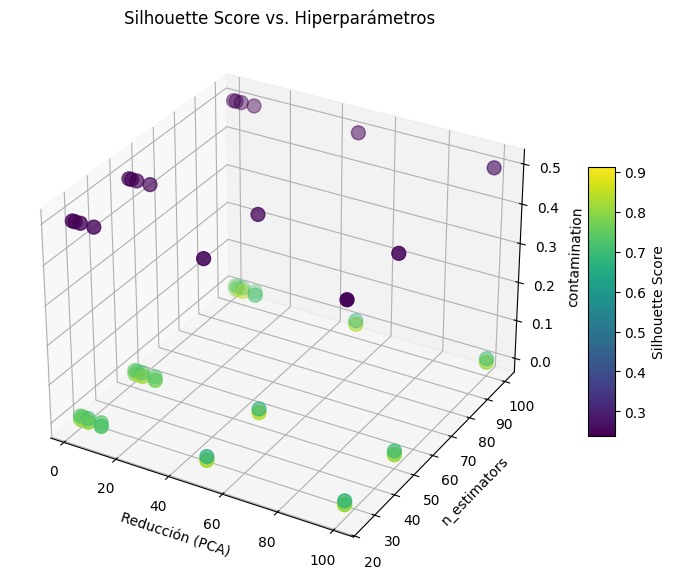

In [6]:

# Extraer los datos para la gráfica
x = results_df['Reducción (PCA)'].values
y = results_df['n_estimators'].values
z = results_df['contamination'].values
scores = results_df['Silhouette Score'].values

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Crear la gráfica de dispersión
scatter = ax.scatter(x, y, z, c=scores, cmap='viridis', s=100)

# Agregar etiquetas a los ejes
ax.set_xlabel('Reducción (PCA)')
ax.set_ylabel('n_estimators')
ax.set_zlabel('contamination')

# Agregar una barra de color para representar el Silhouette Score
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Silhouette Score')

# Título de la gráfica
plt.title("Silhouette Score vs. Hiperparámetros")

# Mostrar la gráfica
plt.show()

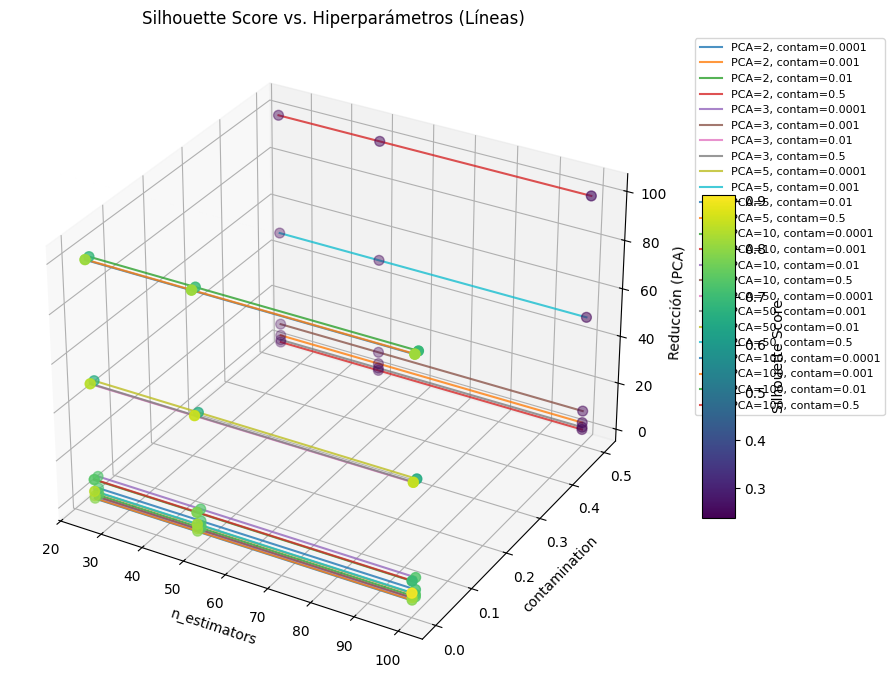

In [7]:

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Agrupar los datos por 'Reducción (PCA)' y 'contamination' para trazar líneas
grouped = results_df.groupby(['Reducción (PCA)', 'contamination'])

for key, group in grouped:
    reduction_pca, contamination = key
    x = group['Reducción (PCA)'].values
    y = group['n_estimators'].values
    z = group['contamination'].values
    scores = group['Silhouette Score'].values
    
    # Trazar una línea para cada grupo
    ax.plot(y, z, x, label=f"PCA={reduction_pca}, contam={contamination}", alpha=0.8)

# Agregar etiquetas a los ejes
ax.set_xlabel('n_estimators')
ax.set_ylabel('contamination')
ax.set_zlabel('Reducción (PCA)')

# Añadir una barra de color para representar el Silhouette Score
sc = ax.scatter(results_df['n_estimators'], results_df['contamination'], results_df['Reducción (PCA)'],
                c=results_df['Silhouette Score'], cmap='viridis', s=50)
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Silhouette Score')

# Añadir leyenda
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)

# Título de la gráfica
plt.title("Silhouette Score vs. Hiperparámetros (Líneas)")

# Mostrar la gráfica
plt.tight_layout()
plt.show()

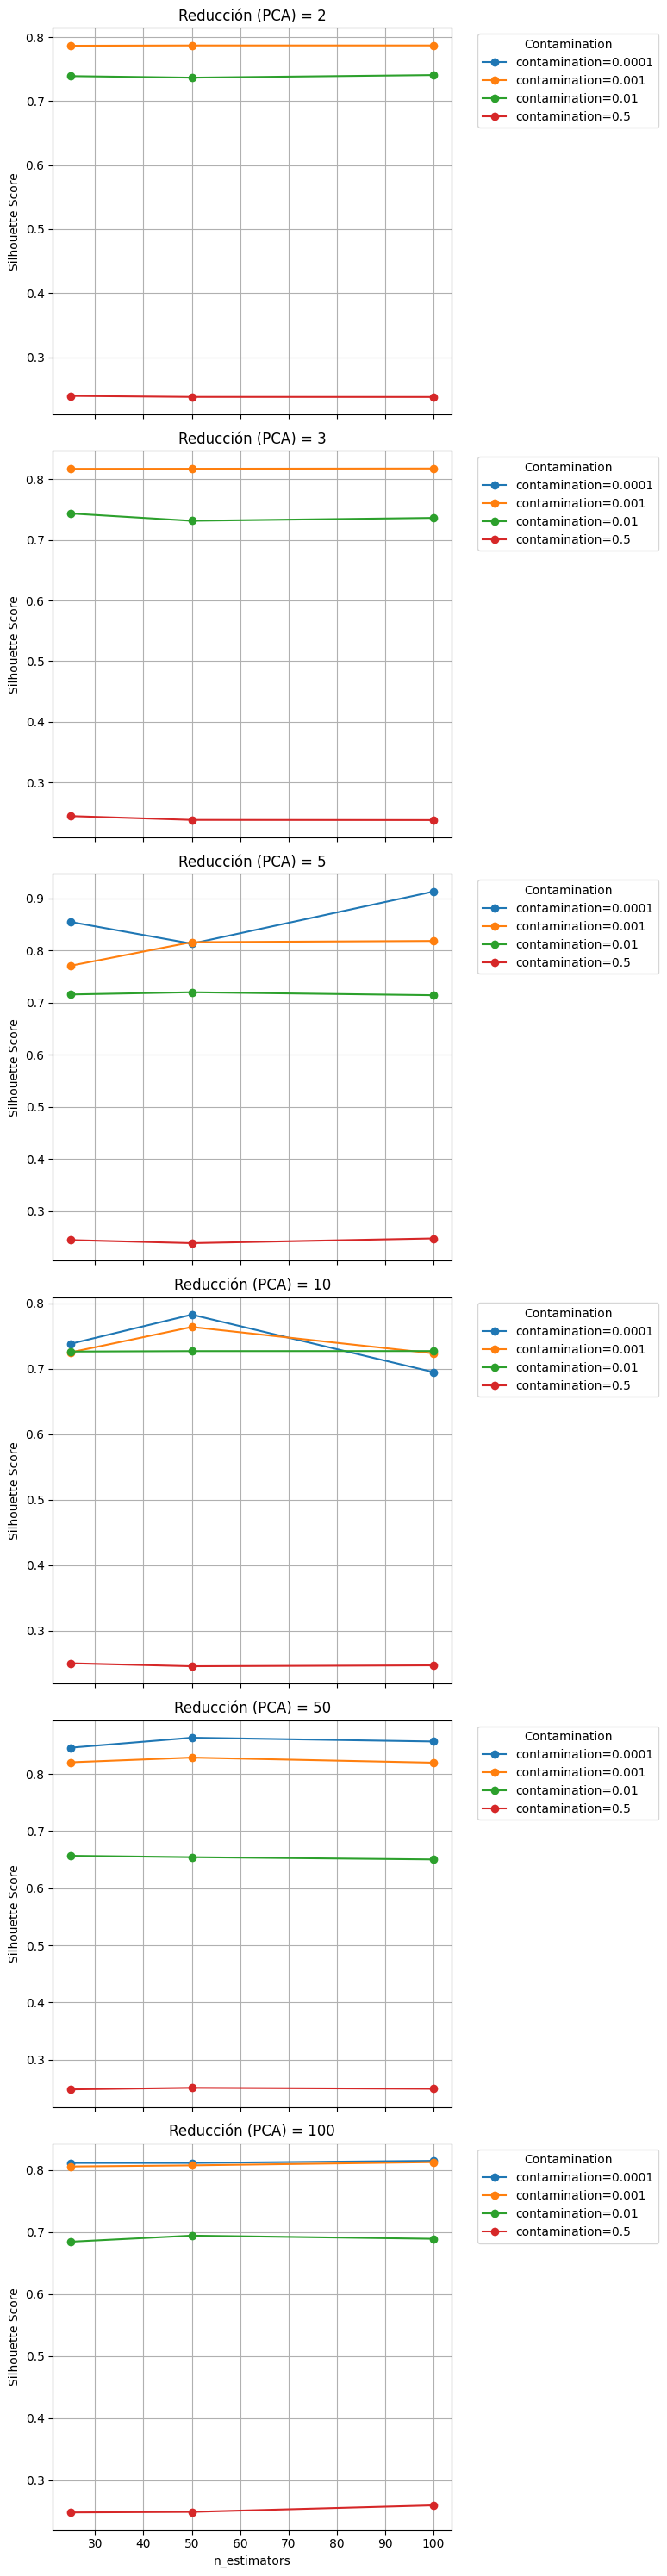

In [8]:

# Obtener los valores únicos de 'Reducción (PCA)'
unique_pca_reductions = sorted(results_df['Reducción (PCA)'].unique())

# Configurar la figura con subplots
fig, axes = plt.subplots(len(unique_pca_reductions), 1, figsize=(10, 5 * len(unique_pca_reductions)), sharex=True)

# Si solo hay un subplot, asegurarse de que axes sea iterable
if not isinstance(axes, np.ndarray):
    axes = [axes]

# Iterar sobre cada valor único de 'Reducción (PCA)'
for i, pca_reduction in enumerate(unique_pca_reductions):
    ax = axes[i]
    
    # Filtrar los datos para el valor actual de 'Reducción (PCA)'
    filtered_data = results_df[results_df['Reducción (PCA)'] == pca_reduction]
    
    # Agrupar por 'contamination' para trazar líneas separadas
    for contamination, group in filtered_data.groupby('contamination'):
        n_estimators = group['n_estimators'].values
        silhouette_scores = group['Silhouette Score'].values
        ax.plot(n_estimators, silhouette_scores, label=f"contamination={contamination}", marker='o')
    
    # Configurar título y etiquetas del eje
    ax.set_title(f'Reducción (PCA) = {pca_reduction}')
    ax.set_ylabel('Silhouette Score')
    ax.legend(title='Contamination', loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.grid(True)

# Configurar etiqueta del eje x común
axes[-1].set_xlabel('n_estimators')

# Ajustar diseño para evitar superposiciones
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Dejar espacio para la leyenda externa

# Mostrar la gráfica
plt.show()

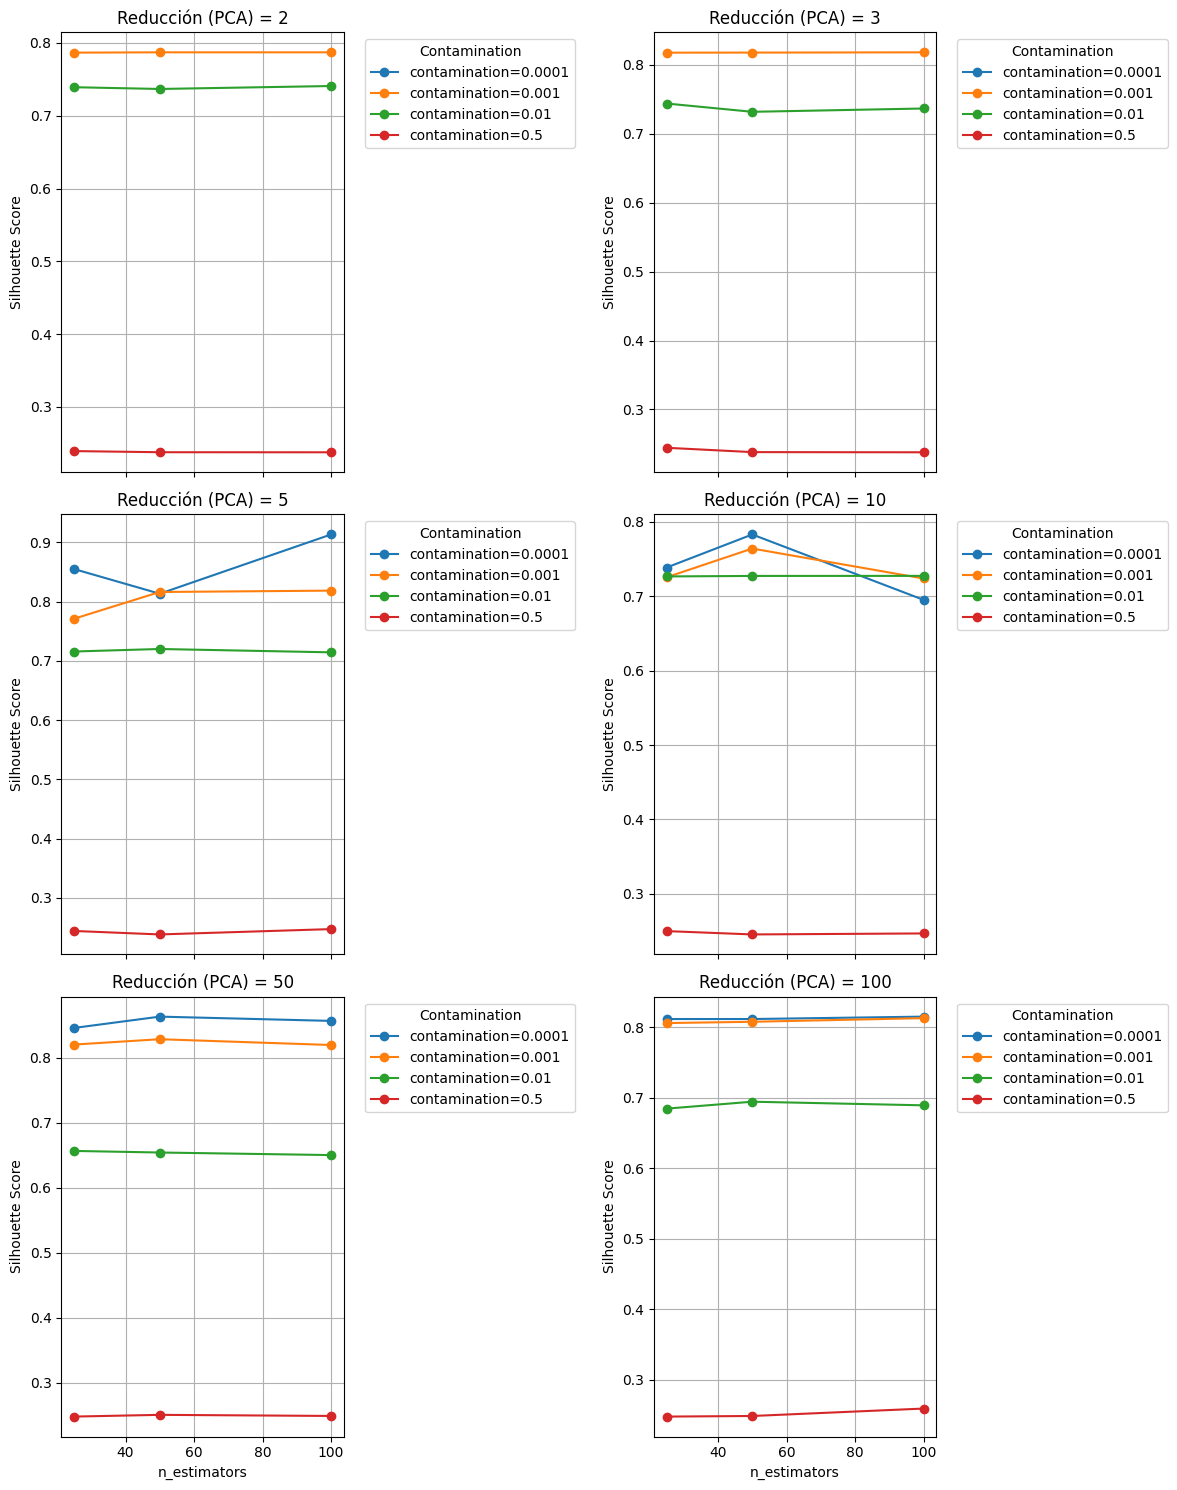

In [9]:

# Obtener los valores únicos de 'Reducción (PCA)'
unique_pca_reductions = sorted(results_df['Reducción (PCA)'].unique())

# Calcular el número de filas necesarias para dos columnas
num_plots = len(unique_pca_reductions)
num_rows = int(np.ceil(num_plots / 2))  # Redondear hacia arriba para asegurar suficientes filas

# Configurar la figura con subplots en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows), sharex=True)

# Aplanar la matriz de ejes si solo hay una fila
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterar sobre cada valor único de 'Reducción (PCA)'
for i, pca_reduction in enumerate(unique_pca_reductions):
    row = i // 2  # Fila actual
    col = i % 2   # Columna actual
    ax = axes[row, col]
    
    # Filtrar los datos para el valor actual de 'Reducción (PCA)'
    filtered_data = results_df[results_df['Reducción (PCA)'] == pca_reduction]
    
    # Agrupar por 'contamination' para trazar líneas separadas
    for contamination, group in filtered_data.groupby('contamination'):
        n_estimators = group['n_estimators'].values
        silhouette_scores = group['Silhouette Score'].values
        ax.plot(n_estimators, silhouette_scores, label=f"contamination={contamination}", marker='o')
    
    # Configurar título y etiquetas del eje
    ax.set_title(f'Reducción (PCA) = {pca_reduction}')
    ax.set_ylabel('Silhouette Score')
    ax.legend(title='Contamination', loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.grid(True)

# Configurar etiqueta del eje x común
for ax in axes[-1, :]:  # Solo los ejes de la última fila tienen etiqueta x
    ax.set_xlabel('n_estimators')

# Ocultar subplots vacíos si hay un número impar de gráficas
if num_plots % 2 != 0:
    axes[-1, -1].axis('off')  # Desactivar el último subplot si no se usa

# Ajustar diseño para evitar superposiciones
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Dejar espacio para la leyenda externa

# Mostrar la gráfica
plt.show()

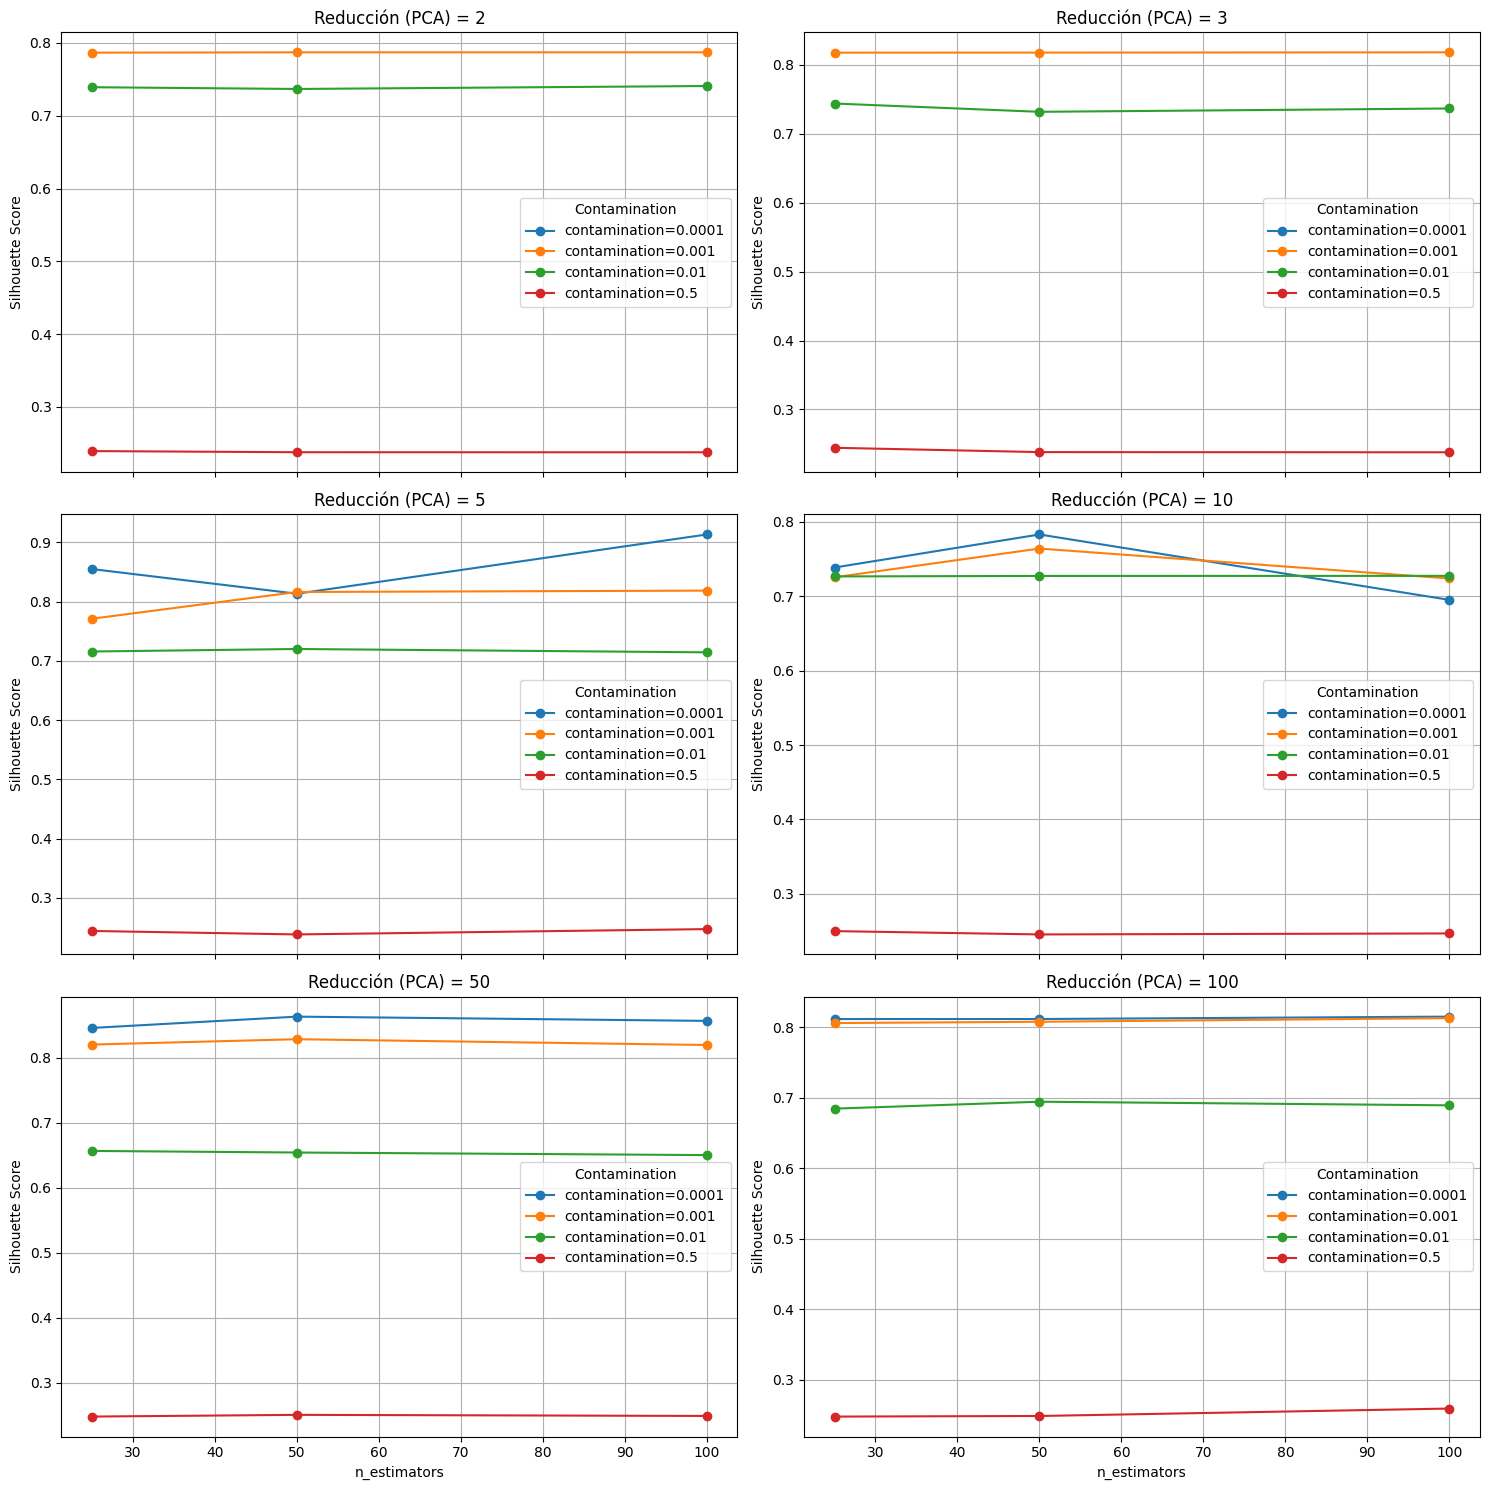

In [10]:

# Obtener los valores únicos de 'Reducción (PCA)'
unique_pca_reductions = sorted(results_df['Reducción (PCA)'].unique())

# Calcular el número de filas necesarias para dos columnas
num_plots = len(unique_pca_reductions)
num_rows = int(np.ceil(num_plots / 2))  # Redondear hacia arriba para asegurar suficientes filas

# Configurar la figura con subplots en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows), sharex=True)

# Aplanar la matriz de ejes si solo hay una fila
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterar sobre cada valor único de 'Reducción (PCA)'
for i, pca_reduction in enumerate(unique_pca_reductions):
    row = i // 2  # Fila actual
    col = i % 2   # Columna actual
    ax = axes[row, col]
    
    # Filtrar los datos para el valor actual de 'Reducción (PCA)'
    filtered_data = results_df[results_df['Reducción (PCA)'] == pca_reduction]
    
    # Agrupar por 'contamination' para trazar líneas separadas
    for contamination, group in filtered_data.groupby('contamination'):
        n_estimators = group['n_estimators'].values
        silhouette_scores = group['Silhouette Score'].values
        ax.plot(n_estimators, silhouette_scores, label=f"contamination={contamination}", marker='o')
    
    # Configurar título y etiquetas del eje
    ax.set_title(f'Reducción (PCA) = {pca_reduction}')
    ax.set_ylabel('Silhouette Score')
    ax.legend(title='Contamination', loc='best')  # Colocar la leyenda dentro del gráfico
    ax.grid(True)

# Configurar etiqueta del eje x común
for ax in axes[-1, :]:  # Solo los ejes de la última fila tienen etiqueta x
    ax.set_xlabel('n_estimators')

# Ocultar subplots vacíos si hay un número impar de gráficas
if num_plots % 2 != 0:
    axes[-1, -1].axis('off')  # Desactivar el último subplot si no se usa

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Grabamos la gráfica
plt.savefig(f"isolation_forest_Silhouette-Score.png")

# Mostrar la gráfica
plt.show()

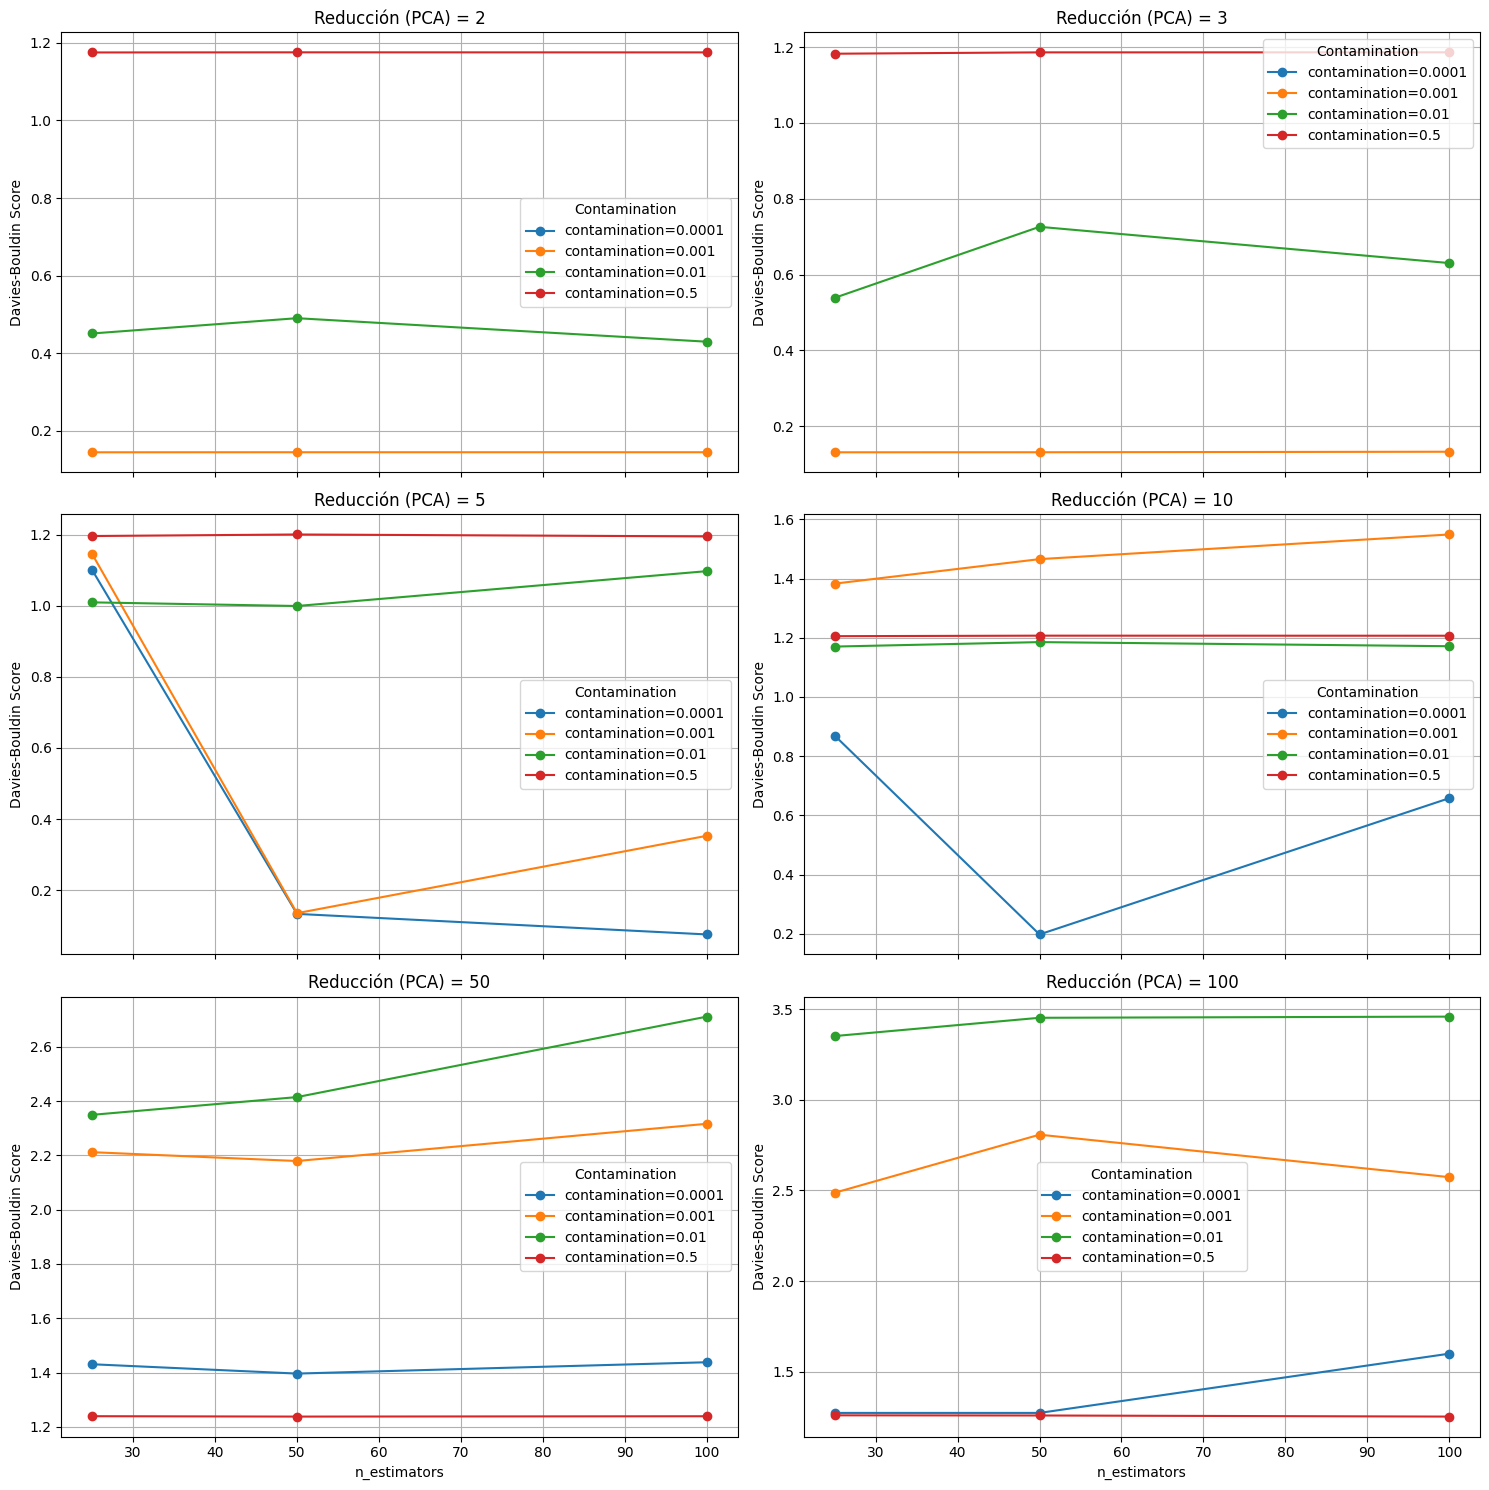

In [11]:

# Obtener los valores únicos de 'Reducción (PCA)'
unique_pca_reductions = sorted(results_df['Reducción (PCA)'].unique())

# Calcular el número de filas necesarias para dos columnas
num_plots = len(unique_pca_reductions)
num_rows = int(np.ceil(num_plots / 2))  # Redondear hacia arriba para asegurar suficientes filas

# Configurar la figura con subplots en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows), sharex=True)

# Aplanar la matriz de ejes si solo hay una fila
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Iterar sobre cada valor único de 'Reducción (PCA)'
for i, pca_reduction in enumerate(unique_pca_reductions):
    row = i // 2  # Fila actual
    col = i % 2   # Columna actual
    ax = axes[row, col]
    
    # Filtrar los datos para el valor actual de 'Reducción (PCA)'
    filtered_data = results_df[results_df['Reducción (PCA)'] == pca_reduction]
    
    # Agrupar por 'contamination' para trazar líneas separadas
    for contamination, group in filtered_data.groupby('contamination'):
        n_estimators = group['n_estimators'].values
        davies_bouldin_scores = group['Davies-Bouldin Score'].values
        ax.plot(n_estimators, davies_bouldin_scores, label=f"contamination={contamination}", marker='o')
    
    # Configurar título y etiquetas del eje
    ax.set_title(f'Reducción (PCA) = {pca_reduction}')
    ax.set_ylabel('Davies-Bouldin Score')
    ax.legend(title='Contamination', loc='best')  # Colocar la leyenda dentro del gráfico
    ax.grid(True)

# Configurar etiqueta del eje x común
for ax in axes[-1, :]:  # Solo los ejes de la última fila tienen etiqueta x
    ax.set_xlabel('n_estimators')

# Ocultar subplots vacíos si hay un número impar de gráficas
if num_plots % 2 != 0:
    axes[-1, -1].axis('off')  # Desactivar el último subplot si no se usa

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Grabamos la gráfica
plt.savefig(f"isolation_forest_Davies-Bouldin-Score.png")

# Mostrar la gráfica
plt.show()

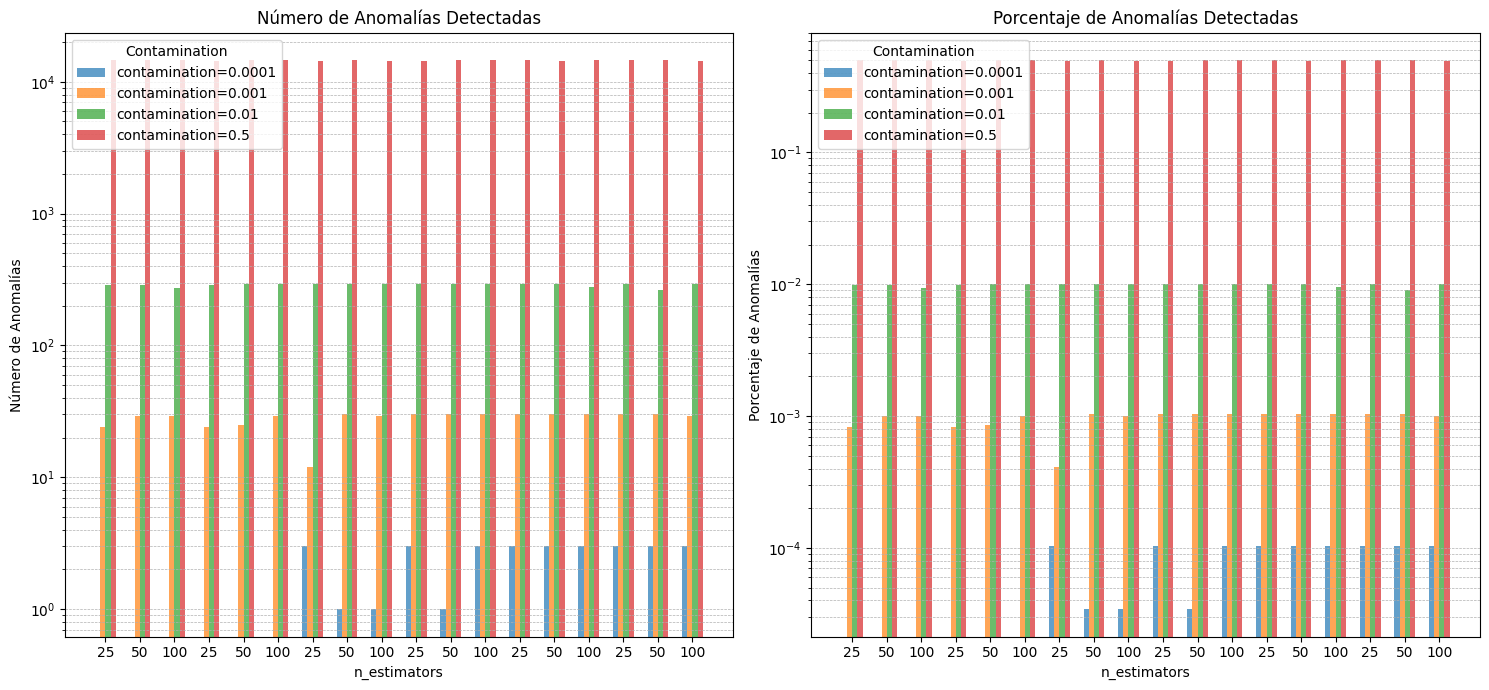

In [12]:

# Obtener los valores únicos de 'contamination'
unique_contaminations = sorted(results_df['contamination'].unique())

# Configurar la figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Ancho de cada barra
bar_width = 0.15  # Ajusta este valor según cuántos grupos tengas y cuánto espacio quieras entre ellos
n_groups = len(unique_contaminations)  # Número de grupos (valores únicos de contamination)
offsets = np.linspace(-bar_width * (n_groups - 1) / 2, bar_width * (n_groups - 1) / 2, n_groups)

# Gráfico 1: Número de anomalías detectadas
for i, contamination in enumerate(unique_contaminations):
    filtered_data = results_df[results_df['contamination'] == contamination]
    n_estimators = filtered_data['n_estimators'].values
    anomalies_detected = filtered_data['Anomalías Detectadas'].values
    
    # Calcular la posición x de cada barra con offset
    x_positions = [x + offsets[i] for x in range(len(n_estimators))]
    axes[0].bar(x_positions, anomalies_detected, width=bar_width, label=f"contamination={contamination}", alpha=0.7)

# Configuración del primer gráfico
axes[0].set_title('Número de Anomalías Detectadas')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Número de Anomalías')
axes[0].legend(title='Contamination')
axes[0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)  # Mostrar grid para escala logarítmica
axes[0].set_yscale('log')  # Escala logarítmica

# Configurar las etiquetas del eje X para mostrar solo una vez cada valor de n_estimators
axes[0].set_xticks(range(len(n_estimators)))  # Posiciones centrales
axes[0].set_xticklabels(n_estimators)  # Etiquetas de n_estimators

# Gráfico 2: Porcentaje de anomalías detectadas
for i, contamination in enumerate(unique_contaminations):
    filtered_data = results_df[results_df['contamination'] == contamination]
    n_estimators = filtered_data['n_estimators'].values
    anomaly_percentage = filtered_data['Porcentaje Anomalías'].values
    
    # Calcular la posición x de cada barra con offset
    x_positions = [x + offsets[i] for x in range(len(n_estimators))]
    axes[1].bar(x_positions, anomaly_percentage, width=bar_width, label=f"contamination={contamination}", alpha=0.7)

# Configuración del segundo gráfico
axes[1].set_title('Porcentaje de Anomalías Detectadas')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('Porcentaje de Anomalías')
axes[1].legend(title='Contamination')
axes[1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)  # Mostrar grid para escala logarítmica
axes[1].set_yscale('log')  # Escala logarítmica

# Configurar las etiquetas del eje X para mostrar solo una vez cada valor de n_estimators
axes[1].set_xticks(range(len(n_estimators)))  # Posiciones centrales
axes[1].set_xticklabels(n_estimators)  # Etiquetas de n_estimators

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar la gráfica
plt.show()